## Automatic Ticket Classification Case Study

#### By Imran Mohammed & Rupali Bansal

## Problem Statement 

You need to build a model that can automatically classify customer complaints based on the products and services that the ticket mentions. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

### Expected tasks to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

### Importing the necessary libraries

In [204]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint


from queue import LifoQueue
import string
from nltk import pos_tag
pd.set_option('max_colwidth',None)
from sklearn.decomposition import NMF

from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import spacy
nlp = spacy.load('en_core_web_sm',disable=['parser','ner'])
import concurrent.futures
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import warnings
warnings.filterwarnings('ignore')

### Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [206]:
# Opening JSON file 
data_set = open("complaints-2021-05-14_08_16.json")# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(data_set)
df=pd.json_normalize(data)

### Data preparation

In [208]:
# Inspect the dataframe to understand the given data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [209]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [210]:
#Assign new column names
df.columns= [col.split('.')[1] if len(col.split('.')) >1 else col for col in df.columns.str.strip('_')]
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [211]:
#percentage null columns in df
percentage_nulls = df.isnull().sum()*100/df.shape[0]
percentage_nulls[percentage_nulls>0].sort_values(ascending=False)

company_public_response      99.994892
tags                         86.081493
sub_issue                    59.117899
sub_product                  13.498397
zip_code                      8.628197
state                         2.542362
consumer_consent_provided     1.287143
dtype: float64

In [212]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace('', np.nan, inplace=True)

In [213]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)

### Text preprocessing - Text Cleaning

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers

In [215]:
def clean_text(text):
    text = text.lower()  # Make the text lowercase
    text = re.sub('\[.*\]','', text).strip() # Remove text in square brackets
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = re.sub('\S*\d\S*\s*','', text).strip()  # Remove words containing numbers
    return text.strip()

In [216]:
cleaned_text = df.complaint_what_happened.apply(lambda x: clean_text(x))

* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].

In [218]:
#Write your function to Lemmatize the texts
def lemmatizer_posfilter(complaint):
    doc = nlp(str(complaint))
    pos_filtered = " ".join(token.lemma_ for token in doc if token.pos_=="NOUN")
    return pos_filtered

In [219]:
%%time
pos_filtered = cleaned_text.apply(lemmatizer_posfilter)

CPU times: user 2min 31s, sys: 3.32 s, total: 2min 34s
Wall time: 2min 35s


In [220]:
#Create a dataframe('clean_df') that will have only the complaints and the lemmatized complaints 
clean_df = pd.DataFrame(zip(cleaned_text, pos_filtered), columns=['complaints', 'pos_filtered_complaints'])
clean_df.sample(5)

,complaints,pos_filtered_complaints
2129,i purchased goods in xxxx on xxxxxxxx for delivery to my home the merchant agreed with me to ship the goods within days and provide me a tracking number they then discussed the shipment several times with me over the course of the following months via email and gave excuse after excuse on why they could not ship the goods to me the transaction included tailoring for a three piece suit two shirts and two ties totaling the merchant still has not sent me the goods after three months and it has become clear that ive been defrauded of my purchase on xxxxxxxx i opened a dispute with chase they sent me only one message through the course of the dispute one email titled a new letter has been added to your account this was apparently to notify me that the merchant had responded to my dispute this was sent to me on xxxxxxxx it did not detail that this was for my dispute and was caught by my spam filter because of this poor communication i was not able to immediately reply to the dispute and it was closed on xxxxxxxx \n\ni didnt know that the dispute was closed until my account was suddenly rebilled for the amount of the transaction on xxxxxxxx this is when i became aware that my case had moved since xxxxxxxx to date i have received no communication from chase bank on why the case was closed in the merchant s favor and no communication that my account was going to be rebilled \n\non xxxxxxxx i sent a fax in to chase to reopen the dispute and provided a full response to the merchant s claims which ive attached to this complaint i was able to show in several areas that the merchant lied outright in their response regarding shipping and regarding the merchant s claim that i never communicated with them the merchant had been in contact with me for several months already and has explicitly been discussing the details of the agreedupon shipment \n\non xxxx i called several chase representatives talking to xxxx xxxx and xxxx a supervisor chase did not have an explanation for why i had not received details on why the case was closed without notice to me or any notice of why the decision was made in the merchant s favor they also told me that my case would be decided in the merchant s favor despite the fact that i was able to demonstrate that the merchant lied several times in their response i also know for a fact that other chase customers have claims open similar to mine with the merchant i was told by chase support that this is essentially a nonissue for them and that visachase will continue to take charges from the merchant despite the fact that theyre clearly defrauding customers \n\nchase did not honor the billing rights set out in my cardholder agreement i was not and have not been notified of their decision to side with the merchant even though they have rebilled my account \n\nthey also told me they need written proof that there was an agreement to ship my goods i have provided this in the email thread with the merchant theyve told me that this proof isnt good enough even though they have never provided any kind of guidelines on their subjective standards its clear from my communication with the vendor that there was an agreement to ship the goods \n\nthirdly chase does not seem to care that the merchant lied several other times in their response their customer support staffs statement that they will still side with the merchant leads me to believe that they do not have their cardholder s interests in mind when it comes to disputes and want to find the easiest way out of the dispute possible even if they side with a merchant that i can show has a track record of defrauding customers,good delivery home merchant good day tracking number shipment time course month email excuse excuse good transaction tailoring piece suit shirt tie merchant good month purchase dispute chase message course dispute email letter account merchant dispute dispute spam filter communication dispute dispute account amount tra

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [222]:
# Write your code here to visualise the data according to the 'Complaint' character length
temp = clean_df.pos_filtered_complaints.str.len()
sns.histplot(temp[temp<temp.quantile(0.99)],shrink=1,kde=True)

<Axes: xlabel='pos_filtered_complaints', ylabel='Count'>

#### Find the top 40 words by frequency among all the articles after processing the text.

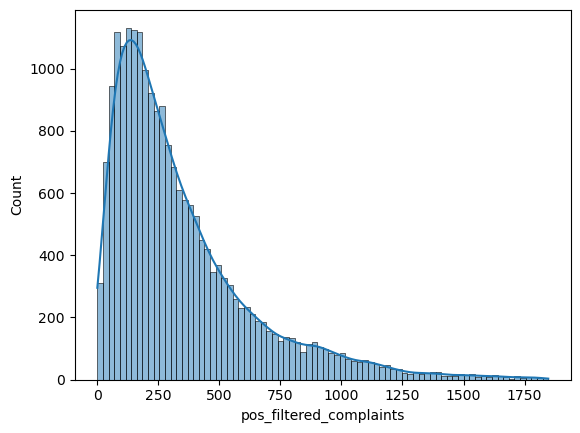

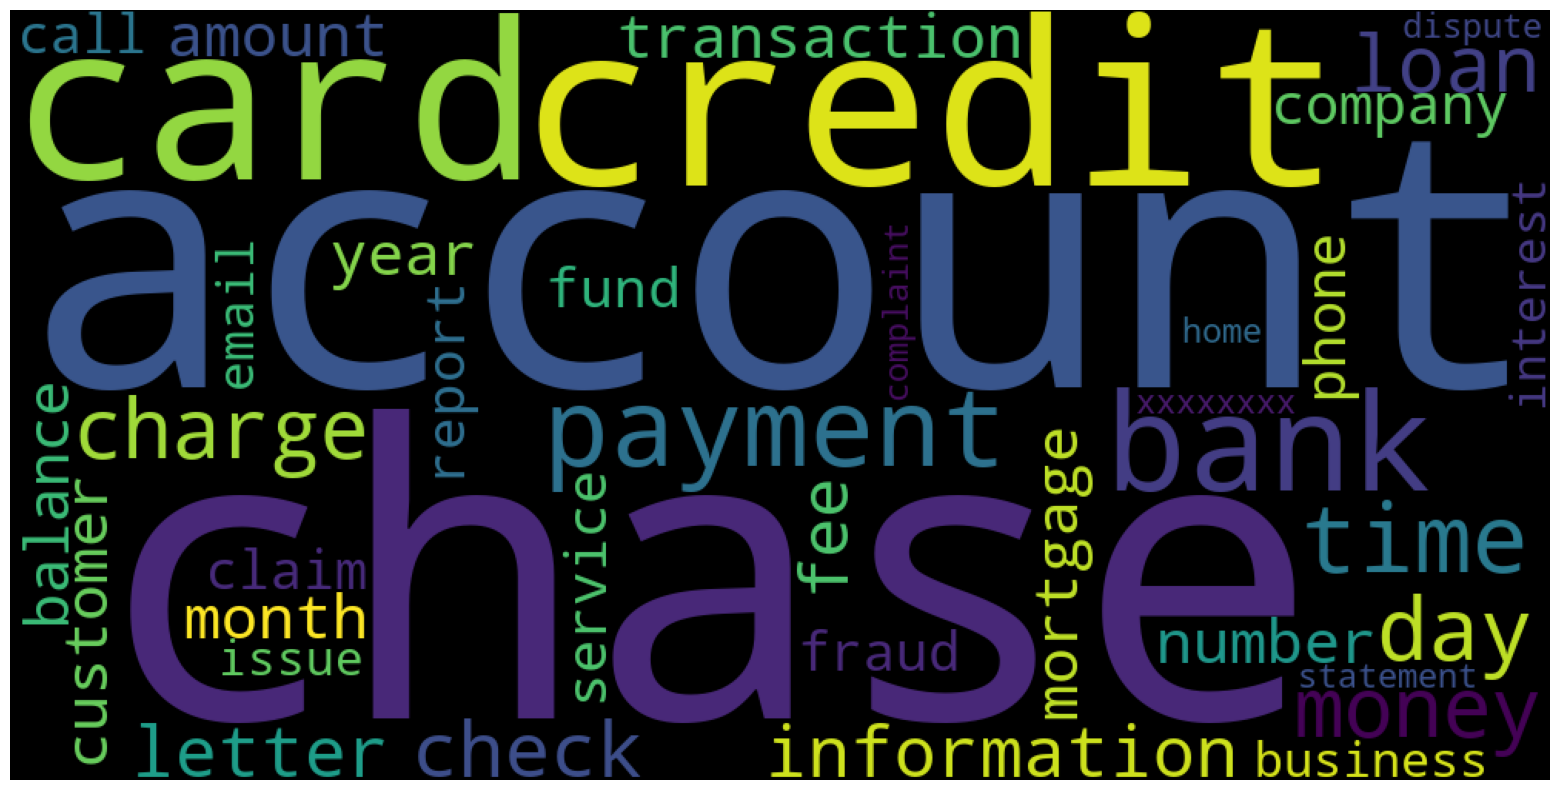

In [224]:
!pip install wordcloud
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
word_cloud = WordCloud(collocations=False, width=1000,height=500,max_words=40,random_state=100,stopwords=STOPWORDS).generate(" ".join(clean_df["pos_filtered_complaints"]))
plt.figure(figsize =(20,10))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

In [225]:
#Removing -PRON- from the text corpus
clean_df['pos_filtered_complaints'] = clean_df['pos_filtered_complaints'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [227]:
def get_top_n_word_from_ngram(clean_df, ngram,n):
    cv = CountVectorizer(stop_words='english', max_features=10000,ngram_range=(ngram,ngram))
    df_grams = cv.fit_transform(clean_df.pos_filtered_complaints).toarray()
    idx = df_grams.sum(axis=0).argsort()[::-1][:30]
    count = df_grams.sum(axis=0)
    df = pd.DataFrame(zip(cv.get_feature_names_out()[idx], count[idx]), columns=['ngram', 'count'])[:n]
    print(df)
    return df
    

In [228]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
sns.barplot(y='ngram', x='count', data=get_top_n_word_from_ngram(clean_df, 1,30))
plt.title('Top 30 unigrams')

          ngram  count
0         chase  60722
1       account  46960
2        credit  32577
3          card  30204
4          bank  21167
5       payment  21129
6          time  15968
7           day  12920
8        charge  12072
9         money  11946
10         loan  10831
11        check  10273
12  information   9628
13       letter   9626
14          fee   8903
15  transaction   8573
16       number   8557
17        month   8451
18         year   8281
19     customer   8117
20     mortgage   7967
21      balance   7735
22      company   7559
23      service   7517
24        phone   7490
25         fund   7017
26       report   6935
27        fraud   6612
28        claim   6599
29        email   5803


Text(0.5, 1.0, 'Top 30 unigrams')

In [229]:
#Print the top 10 words in the unigram frequency
sns.barplot(y='ngram', x='count', data=get_top_n_word_from_ngram(clean_df, 1,10))
plt.title('Top 10 unigrams')


     ngram  count
0    chase  60722
1  account  46960
2   credit  32577
3     card  30204
4     bank  21167
5  payment  21129
6     time  15968
7      day  12920
8   charge  12072
9    money  11946


Text(0.5, 1.0, 'Top 10 unigrams')

In [230]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
sns.barplot(y='ngram', x='count', data=get_top_n_word_from_ngram(clean_df, 2,30))
plt.title('Top 30 bigrams')


               ngram  count
0        credit card  12850
1      credit report   3843
2      account chase   3792
3         chase bank   3698
4      chase account   3466
5       chase credit   3382
6   customer service   3057
7    account account   2784
8       bank account   2521
9   checking account   2402
10        debit card   1986
11        card chase   1985
12        chase card   1906
13      card account   1783
14      credit score   1710
15   payment payment   1669
16    account credit   1634
17       chase chase   1484
18     money account   1440
19    chase customer   1399
20      account bank   1353
21      letter chase   1286
22     payment chase   1272
23      phone number   1261
24         card card   1259
25      business day   1249
26    account number   1180
27       card credit   1179
28      card company   1157
29     chase payment   1124


Text(0.5, 1.0, 'Top 30 bigrams')

In [231]:
#Print the top 10 words in the bigram frequency
sns.barplot(y='ngram', x='count', data=get_top_n_word_from_ngram(clean_df, 2,10))
plt.title('Top 10 bigrams')

              ngram  count
0       credit card  12850
1     credit report   3843
2     account chase   3792
3        chase bank   3698
4     chase account   3466
5      chase credit   3382
6  customer service   3057
7   account account   2784
8      bank account   2521
9  checking account   2402


Text(0.5, 1.0, 'Top 10 bigrams')

In [232]:
#Write your code here to find the top 30 trigram frequency among the complaints in
sns.barplot(y='ngram', x='count', data=get_top_n_word_from_ngram(clean_df, 3,30))
plt.title('Top 30 trigrams')


                              ngram  count
0                 chase credit card   2242
1               credit card account   1106
2               credit card company   1004
3                 credit card chase    889
4            chase customer service    635
5                credit card credit    577
6             inquiry credit report    556
7               account credit card    466
8                  card credit card    465
9                chase bank account    457
10            account chase account    405
11          credit reporting agency    385
12               charge credit card    380
13             credit report credit    376
14  customer service representative    351
15            account credit report    348
16             credit reporting act    335
17              credit card payment    332
18               account chase bank    303
19              chase account chase    299
20                 bank credit card    291
21              credit card balance    287
22         

Text(0.5, 1.0, 'Top 30 trigrams')

In [233]:
#Print the top 10 words in the trigram frequency
#Write your code here to find the top 30 trigram frequency among the complaints in
sns.barplot(y='ngram', x='count', data=get_top_n_word_from_ngram(clean_df, 3,10))
plt.title('Top 10 trigrams')


                    ngram  count
0       chase credit card   2242
1     credit card account   1106
2     credit card company   1004
3       credit card chase    889
4  chase customer service    635
5      credit card credit    577
6   inquiry credit report    556
7     account credit card    466
8        card credit card    465
9      chase bank account    457


Text(0.5, 1.0, 'Top 10 trigrams')

#### remove the masked text

In [235]:
clean_df['x_removed']=clean_df['pos_filtered_complaints'].str.replace(r"[x]+",'',regex=True)

In [236]:
clean_df['x_removed']=clean_df['x_removed'].str.replace(r"chase",'')

### Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [238]:
#Write your code here to initialise the TfidfVectorizer 
tfidf=TfidfVectorizer(max_df=0.95,min_df=5,stop_words='english',ngram_range=(1,2))


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [240]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
document_matrix = tfidf.fit_transform(clean_df['x_removed'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [243]:
def get_most_common_word_in_each_topic(H,num_words):
    out = {}
    for i in range(H.shape[0]):
        print(f"\n###################### TOPIC {i+1} ###################")
        idx = H.iloc[i,:].argsort()[::-1][:num_words].values.tolist()
        print (', '.join(H.iloc[1,idx[:num_words]].index.values.tolist()))

In [244]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(random_state=40,n_components=num_topics)
tokens = tfidf.get_feature_names_out()
W = nmf_model.fit_transform(document_matrix)
H = pd.DataFrame(nmf_model.components_)
H.columns = tokens
H.head(5)

,aa,aarp,aarp card,ability,ability account,ability bank,ability business,ability card,ability charge,ability company,...,yesterday representative,yesterday today,yesterday transaction,yield,yr,yrs,zip,zip code,zombie,zone
0,0.000565,0.000000,0.000000,0.022862,0.009389,0.003313,0.000000,0.000000,0.000000,0.000000,...,0.000984,0.001689,0.003050,0.001842,0.001079,0.000570,0.000763,0.000000,0.000000,0.000734
1,0.000000,0.008908,0.005322,0.018018,0.001617,0.000000,0.000659,0.001394,0.000455,0.000136,...,0.000426,0.001137,0.000272,0.000000,0.000000,0.004572,0.003171,0.003308,0.000609,0.000000
2,0.000312,0.000000,0.000000,0.039041,0.000000,0.000000,0.001809,0.000258,0.000000,0.000776,...,0.000151,0.000364,0.000000,0.001346,0.007304,0.012255,0.005199,0.005402,0.000958,0.005290
3,0.000257,0.000701,0.000998,0.014552,0.000037,0.000000,0.001942,0.000000,0.000000,0.000000,...,0.000201,0.000000,0.000000,0.000000,0.001041,0.000000,0.000728,0.000212,0.000967,0.000000
4,0.000120,0.000714,0.000000,0.014016,0.000000,0.000000,0.000122,0.000367,0.002437,0.000812,...,0.000000,0.001416,0.001229,0.000000,0.002037,0.001057,0.006440,0.004207,0.000000,0.003286


In [245]:
#TOP 30 words for each topic
get_most_common_word_in_each_topic(H,30)


###################### TOPIC 1 ###################
account, check, bank, money, fund, account account, deposit, branch, checking, day, fee, bank account, checking account, business, account bank, number, transaction, customer, money account, transfer, balance, saving, time, check account, account money, fund account, reason, overdraft, claim, saving account

###################### TOPIC 2 ###################
card, credit, credit card, balance, card credit, account, card account, card card, score, limit, year, credit score, fee, card company, month, point, company, application, offer, pur, payment, account credit, credit limit, service, reason, customer, time, reward, freedom, card balance

###################### TOPIC 3 ###################
payment, loan, mortgage, home, modification, payment payment, month, time, year, rate, property, mortgage payment, balance, foreclosure, letter, fee, loan modification, house, statement, day, date, document, bank, auto, sale, payment month, credit, 

## Topics Identified
- Topic 0: Bank Account
- Topic 1: Card Services
- Topic 2: Loan Services
- Topic 3: Others
- Topic 4: Theft/Dispute Reporting

## Mapping from Index to Topic
- ITOS: Integer to String
- STOI: String to Integer

In [248]:
itos = {
    0: 'Bank Account',
    1: 'Card Services',
    2: 'Loan Services',
    3: 'Others',
    4: 'Theft/Dispute'
}

stoi = {v:k for k,v in itos.items()}
print(itos)
print(stoi)

{0: 'Bank Account', 1: 'Card Services', 2: 'Loan Services', 3: 'Others', 4: 'Theft/Dispute'}
{'Bank Account': 0, 'Card Services': 1, 'Loan Services': 2, 'Others': 3, 'Theft/Dispute': 4}


In [249]:
def get_idx_of_max_topic(x):
    idx = x.argsort()[::-1]
    idx = x[idx].index[0]
    return idx

In [250]:
W_df =pd.DataFrame(W, columns=stoi.keys())
W_df['assigned'] = W_df[stoi.keys()].apply(get_idx_of_max_topic,axis=1)
clean_df['Topic'] = W_df['assigned']
W_df.head()

,Bank Account,Card Services,Loan Services,Others,Theft/Dispute,assigned
0,0.011194,0.002409,0.010888,0.007586,0.006852,Bank Account
1,0.006037,0.009981,0.002972,0.000017,0.007517,Card Services
2,0.000000,0.029394,0.000000,0.012414,0.003059,Card Services
3,0.013664,0.023397,0.003703,0.039226,0.006668,Others
4,0.052759,0.000000,0.000000,0.000000,0.000617,Bank Account


In [251]:
# Print the first 5 complaint for each of the Topics
temp = clean_df.groupby('Topic').head(5)
temp[['complaints','Topic']].sort_values('Topic')
temp

,complaints,pos_filtered_complaints,x_removed,Topic
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop service debt verification statement bank debt mail month debt right information consumer chase account thank advance help,morning name stop service debt verification statement bank debt mail month debt right information consumer account thank advance help,Bank Account
1,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,card agent anniversary date agent information order account anniversary date consent recording agent,card agent anniversary date agent information order account anniversary date consent recording agent,Card Services
2,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card application identity consent service credit identity applicant,card application identity consent service credit identity applicant,Card Services
3,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,ticket offer ticket reward card information offer minute screen decision bank chase bank notification screen chase representative application information offer credit offer account statement ticket account application representative application request application contrary chase representative chase fact credit account name credit report chase information credit report application error,ticket offer ticket reward card information offer minute screen decision bank bank notification screen representative application information offer credit offer account statement ticket account application representative application request application contrary representative fact credit account name credit report information credit report application error,Others
4,my grand son give me check for i deposit it into my chase account after fu

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
 - Bank Account services
 - Credit card or prepaid card
 - Theft/Dispute Reporting
 - Mortgage/Loan
 - Others

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [254]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=clean_df[['pos_filtered_complaints','Topic']]
training_data.head()

,pos_filtered_complaints,Topic
0,morning name stop service debt verification statement bank debt mail month debt right information consumer chase account thank advance help,Bank Account
1,card agent anniversary date agent information order account anniversary date consent recording agent,Card Services
2,chase card application identity consent service credit identity applicant,Card Services
3,ticket offer ticket reward card information offer minute screen decision bank chase bank notification screen chase representative application information offer credit offer account statement ticket account application representative application request application contrary chase representative chase fact credit account name credit report chase information credit report application error,Others
4,son check chase account fund chase bank account money son check money chase bank money son time check owner country time date check number claim number chase,Bank Account


### Train-Test Split

In [256]:
X_train, X_test, y_train, y_test = train_test_split(training_data['pos_filtered_complaints'],training_data['Topic'],test_size=0.1)
print(f'X_train.shape={X_train.shape}')
print(f'X_test.shape={X_test.shape}')
print(f'y_train.shape={y_train.shape}')
print(f'y_test.shape={y_test.shape}')

X_train.shape=(18964,)
X_test.shape=(2108,)
y_train.shape=(18964,)
y_test.shape=(2108,)


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


### TFIDF Vectorizer

In [259]:
vectorizer = TfidfVectorizer(max_df=0.95,min_df=5)
X_train_vc = vectorizer.fit_transform(X_train)
y_train_vc = y_train.map(stoi)
X_test_vc = vectorizer.transform(X_test)
y_test_vc = y_test.map(stoi)

print(f'X_train_vc.shape={X_train_vc.shape}')
print(f'X_test_vc.shape={X_test_vc.shape}')
print(f'y_train_vc.shape={y_train_vc.shape}')
print(f'y_test_vc.shape={y_test_vc.shape}')


X_train_vc.shape=(18964, 3407)
X_test_vc.shape=(2108, 3407)
y_train_vc.shape=(18964,)
y_test_vc.shape=(2108,)


### One Hot Encoding Target

In [261]:
label_binarizer = LabelBinarizer().fit(y_train_vc)
y_train_vc_onehot = label_binarizer.transform(y_train_vc)
y_test_vc_onehot = label_binarizer.transform(y_test_vc)
print(f"y_train_vc_onehot.shape={y_train_vc_onehot.shape}")
print(f"y_test_vc_onehot.shape={y_test_vc_onehot.shape}")

y_train_vc_onehot.shape=(18964, 5)
y_test_vc_onehot.shape=(2108, 5)


In [262]:
def plot_model(model,dataset='test'):
    if dataset!='test':
        X = X_train_vc
        y = y_train_vc
        y_onehot = y_train_vc_onehot
    else:
        X = X_test_vc
        y = y_test_vc
        y_onehot = y_test_vc_onehot
    
    y_proba = model.predict_proba(X)
    fig , (ax1,ax2) = plt.subplots(1,2)
    fig.set_size_inches((10,5))
    
    RocCurveDisplay.from_predictions(
        y_onehot.ravel(),
        y_proba.ravel(),
        name="micro-average OvR",
        color="darkorange",
        ax=ax1
    )
    
    ax1.axis("Square")
    ax1.set_xlabel("False Positive Rate")
    ax1.set_ylabel("True Positive Rate")
    ax1.set_title("Micro-averaged One-vs-Rest\nReceiver Operating Characterstic")
    ax1.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),)
    
    disp = ConfusionMatrixDisplay(confusion_matrix(y, lr.predict(X)))
    disp.plot(ax=ax2)
    ax2.set_title("Confusion Matrix")
    
    fig.suptitle(f'############## {dataset.upper()} DATA METRICS ########################')
    plt.legend()
    plt.show()

In [263]:
def print_classification_report(model, dataset='train'):
    print("-"*100)
    print("Classification Report")
    print("-"*100)
    
    if dataset=='train':
        X = X_train_vc
        y = y_train_vc
    else:
        X = X_test_vc
        y = y_test_vc
    
    pred = model.predict(X)
    print(classification_report(y, pred))
    return accuracy_score(y,pred), precision_score(y, pred, average='macro'), recall_score(y,pred,average='macro')

In [264]:
def plot(model,model_desc,dataset_type):
    plot_model(model,dataset=dataset_type)
    accuracy, precision, recall = print_classification_report(model, dataset=dataset_type)
    metrics.append((model_desc,dataset_type,accuracy,precision,recall))

### Logsitic Regression

In [266]:
metrics = []

# build model and train

lr = LogisticRegression(verbose=True, max_iter=500)
lr.fit(X_train_vc, y_train_vc)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        17040     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60944D+00    |proj g|=  1.07140D-01


 This problem is unconstrained.



At iterate   50    f=  2.45115D-01    |proj g|=  5.44639D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
17040     58     61      1     0     0   6.396D-05   2.450D-01
  F =  0.24501251238923216     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


LogisticRegression(max_iter=500, verbose=True)

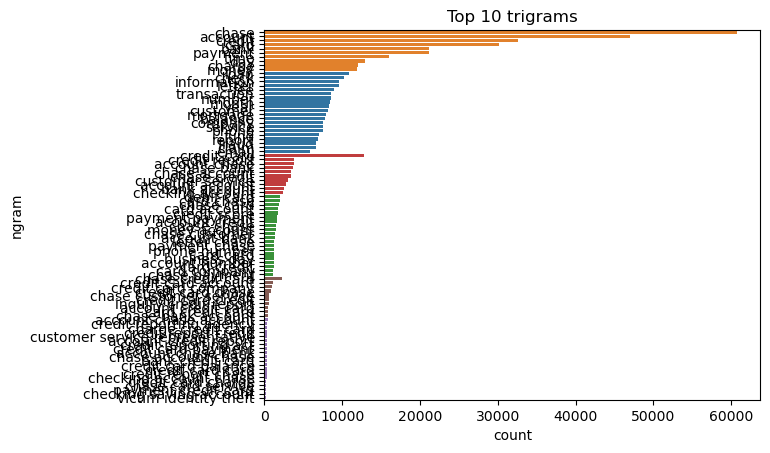

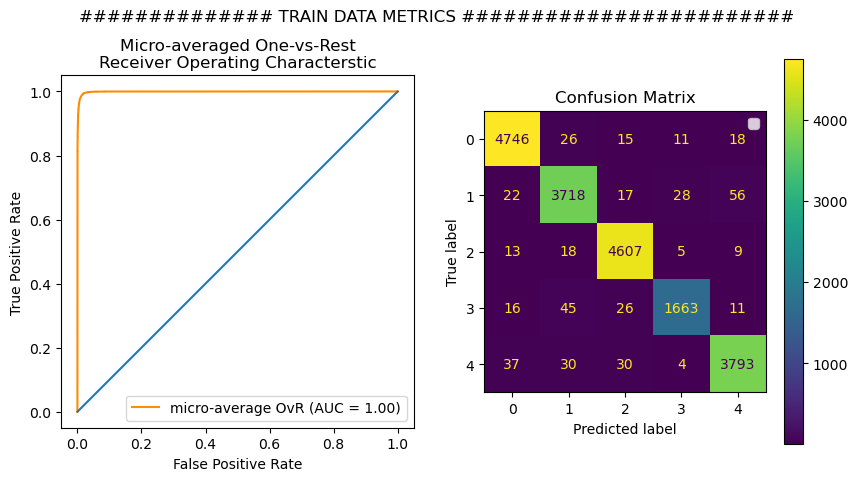

----------------------------------------------------------------------------------------------------
Classification Report
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4816
           1       0.97      0.97      0.97      3841
           2       0.98      0.99      0.99      4652
           3       0.97      0.94      0.96      1761
           4       0.98      0.97      0.97      3894

    accuracy                           0.98     18964
   macro avg       0.98      0.97      0.97     18964
weighted avg       0.98      0.98      0.98     18964



In [267]:
plot(lr,'Logistic Regression','train')

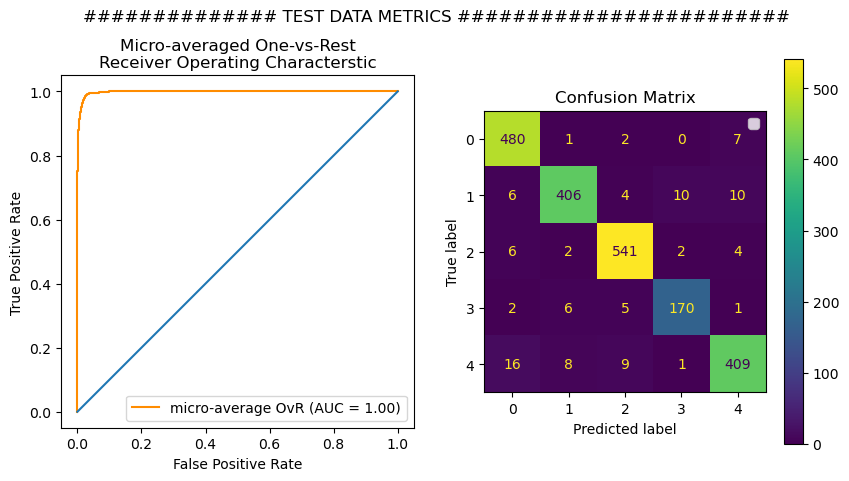

----------------------------------------------------------------------------------------------------
Classification Report
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       490
           1       0.96      0.93      0.95       436
           2       0.96      0.97      0.97       555
           3       0.93      0.92      0.93       184
           4       0.95      0.92      0.94       443

    accuracy                           0.95      2108
   macro avg       0.95      0.95      0.95      2108
weighted avg       0.95      0.95      0.95      2108



In [268]:
plot(lr,'Logistic Regression','test')

### Random Forest

In [270]:
%%time

random_forest = RandomForestClassifier()
param_dist = {
    'criterion' : ['gini', 'entropy'] # Strategy used at each node to split is gini impurtiy or information gain(entropy)
    ,'max_depth': np.arange(1,100) #maximum depth of tree
    ,'min_samples_split': np.arange(2,50) #minimum numbers of samples required to split an internal node
    ,'min_samples_leaf': np.arange(1, 50) # Minimum number of samples required to be a leaf node
    , 'max_features': ['sqrt', 'log2'] #Number of features to consider when Looking for the best split
}
random_search = RandomizedSearchCV(random_forest, param_dist, verbose=1,n_jobs=-1)
random_search.fit(X_train_vc, y_train_vc)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 2.85 s, sys: 176 ms, total: 3.03 s
Wall time: 10.9 s


RandomizedSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75...
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
                   verbose=1)

### Best Params

In [272]:
print(f"random_search.best_score_={random_search.best_score_}")
print(f"random_search.best_estimator_={random_search.best_estimator_}")

random_search.best_score_=0.8670110858220952
random_search.best_estimator_=RandomForestClassifier(criterion='entropy', max_depth=39, min_samples_split=38)


## Mean Test Score Over Training

In [274]:
rf_cv_df = pd.DataFrame(random_search.cv_results_).sort_values(by='mean_test_score',ascending=False)
sns.barplot(y=rf_cv_df['mean_test_score'], x=np.arange(len(rf_cv_df)))

<Axes: ylabel='mean_test_score'>

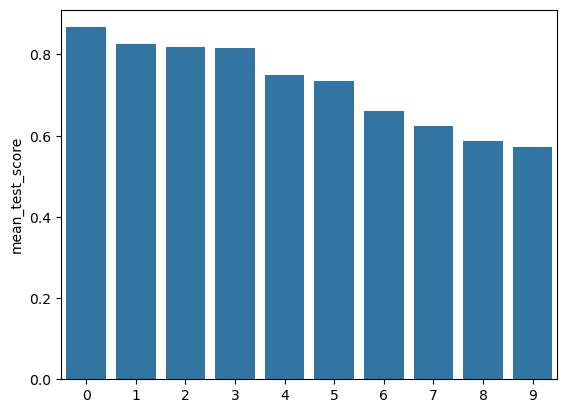

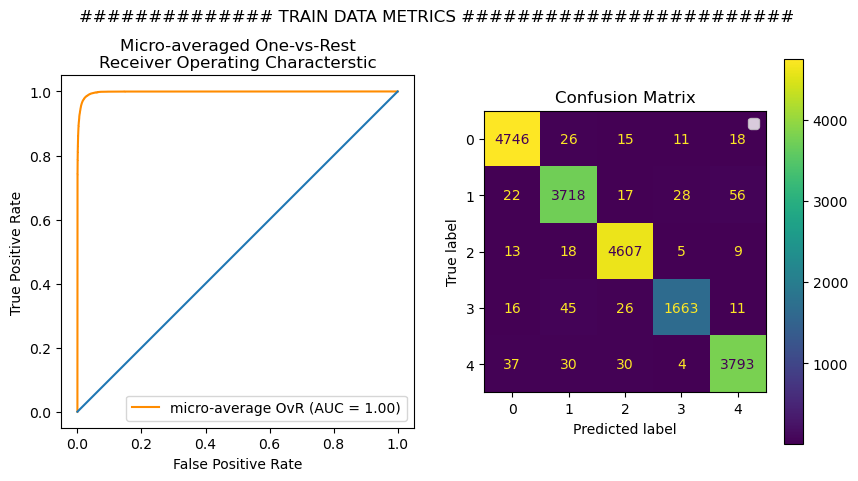

----------------------------------------------------------------------------------------------------
Classification Report
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4816
           1       0.96      0.97      0.97      3841
           2       0.98      0.98      0.98      4652
           3       0.98      0.94      0.96      1761
           4       0.98      0.95      0.96      3894

    accuracy                           0.97     18964
   macro avg       0.97      0.97      0.97     18964
weighted avg       0.97      0.97      0.97     18964



In [275]:
plot(random_search.best_estimator_,'Random Forest Regression','train')

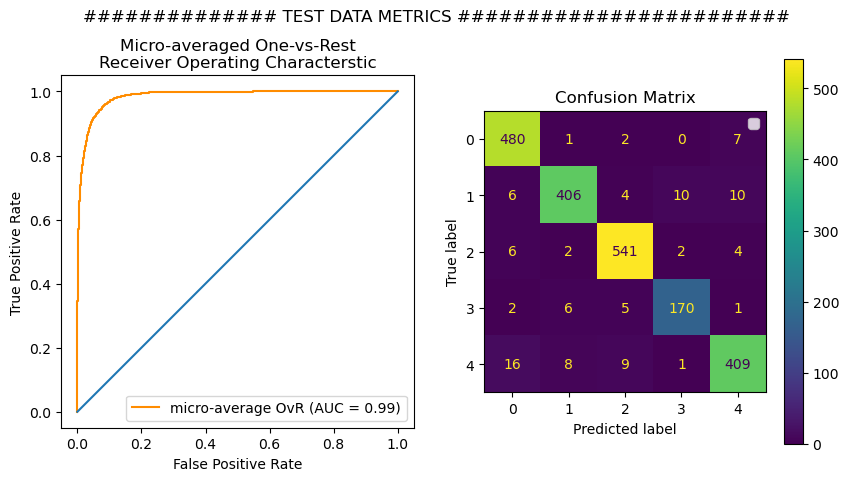

----------------------------------------------------------------------------------------------------
Classification Report
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       490
           1       0.85      0.86      0.86       436
           2       0.92      0.94      0.93       555
           3       0.93      0.83      0.88       184
           4       0.89      0.77      0.83       443

    accuracy                           0.88      2108
   macro avg       0.88      0.87      0.87      2108
weighted avg       0.88      0.88      0.87      2108



In [276]:
plot(random_search.best_estimator_,'Random Forest Regression','test')

### Multinomial NB Classifer

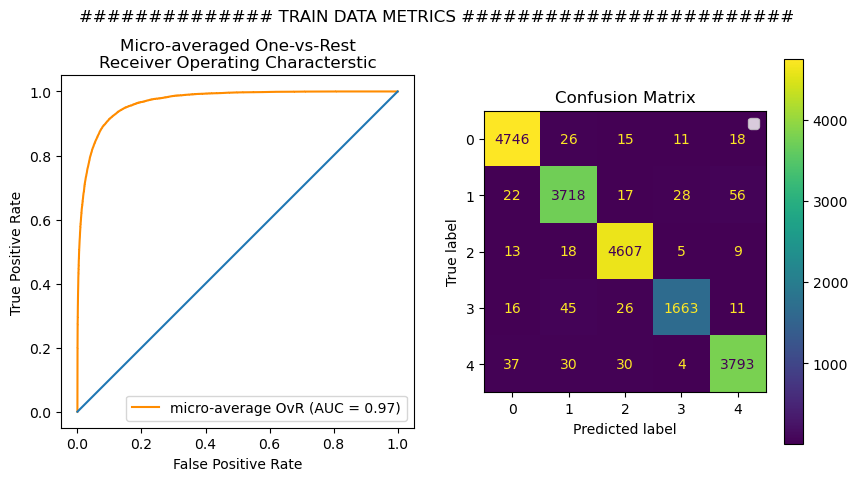

----------------------------------------------------------------------------------------------------
Classification Report
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.90      0.85      4816
           1       0.76      0.78      0.77      3841
           2       0.85      0.88      0.86      4652
           3       0.87      0.68      0.76      1761
           4       0.83      0.76      0.79      3894

    accuracy                           0.82     18964
   macro avg       0.82      0.80      0.81     18964
weighted avg       0.82      0.82      0.82     18964



In [278]:
mnb = MultinomialNB()
mnb.fit(X_train_vc, y_train_vc)
plot(mnb,'MNB Regression','train')

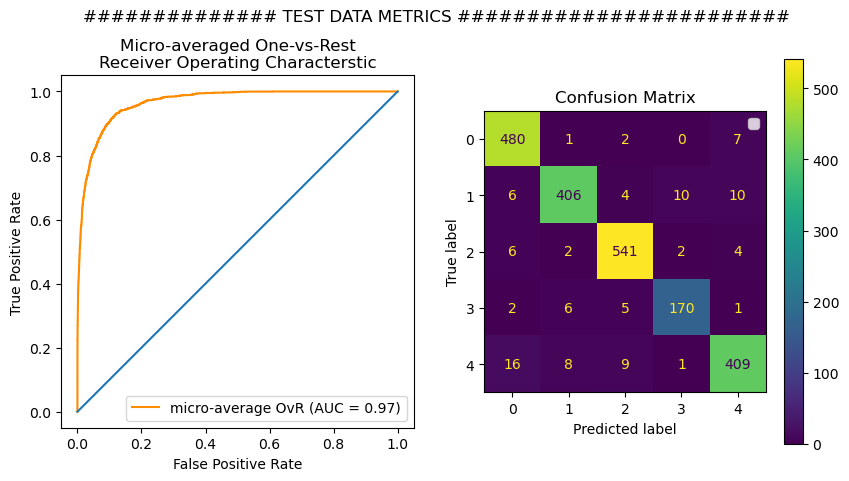

----------------------------------------------------------------------------------------------------
Classification Report
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       490
           1       0.73      0.72      0.73       436
           2       0.87      0.90      0.88       555
           3       0.83      0.70      0.76       184
           4       0.82      0.68      0.74       443

    accuracy                           0.80      2108
   macro avg       0.80      0.78      0.79      2108
weighted avg       0.80      0.80      0.80      2108



In [279]:
plot(mnb,'MNB Regression','test')

### Comparing the Models

In [281]:
metrics_df = pd.DataFrame(metrics, columns=['Model Name', 'Phase', 'Accuracy', 'Precision', 'Recall']).reset_index()
metrics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       6 non-null      int64  
 1   Model Name  6 non-null      object 
 2   Phase       6 non-null      object 
 3   Accuracy    6 non-null      float64
 4   Precision   6 non-null      float64
 5   Recall      6 non-null      float64
dtypes: float64(3), int64(1), object(2)
memory usage: 420.0+ bytes


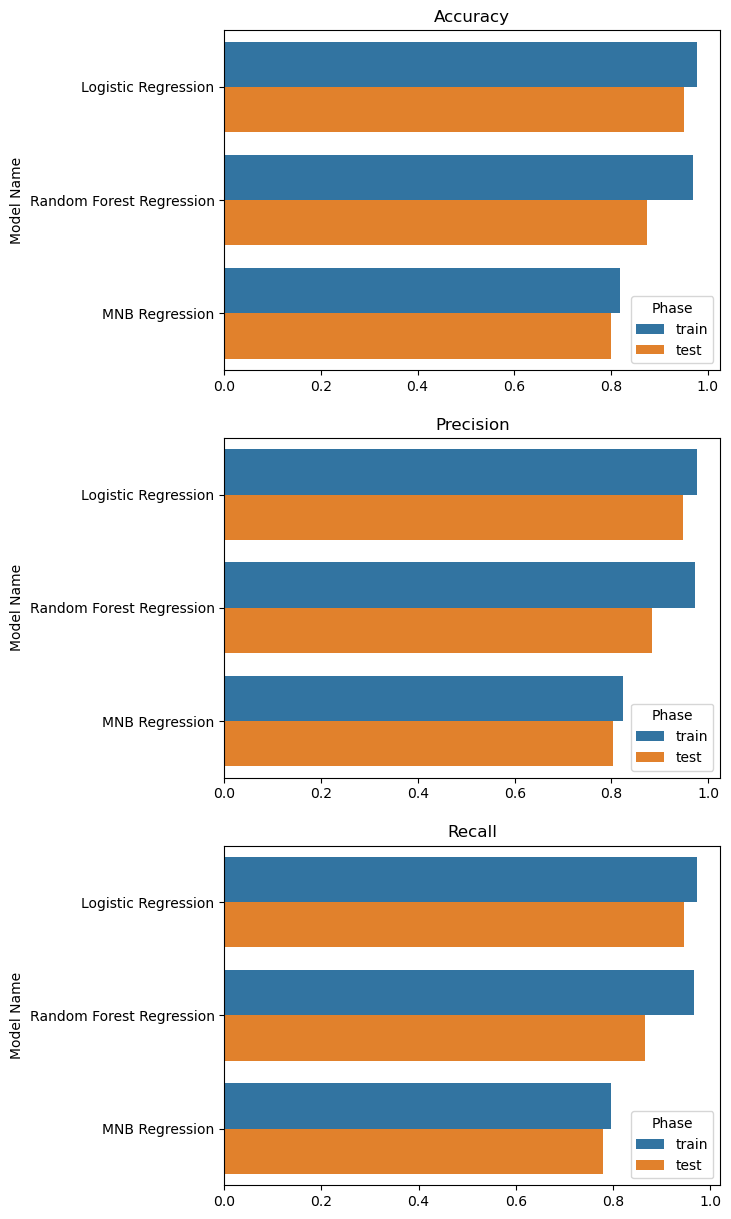

In [282]:
# plotting above metrics dataframe
fig,ax = plt.subplots(3,1)
fig.set_figheight(15)
sns.barplot(data=metrics_df, y='Model Name',x='Accuracy',hue='Phase',ax=ax[0])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('')
sns.barplot(data=metrics_df[['Model Name','Precision','Phase']], y='Model Name', x='Precision',hue='Phase',ax=ax[1])
ax[1].set_title('Precision')
ax[1].set_xlabel('')

sns.barplot(data=metrics_df[['Model Name', 'Recall', 'Phase']], y='Model Name',x='Recall',hue='Phase',ax=ax[2])
ax[2].set_title('Recall')
ax[2].set_xlabel('')

plt.show()

## Logistic Regression Performs the best

 - Accuracy 95%
 - Precision 95%
 - Recall 95%

## Manual Validation for some Complaints

In [285]:
rand_idx = y_test_vc.sample(10).index #10 random samples for validation

for idx in rand_idx:
    statement = clean_df['complaints'][idx]
    actual_output = clean_df['Topic'][idx]
    
    sample = vectorizer.transform([clean_df['complaints'][idx]])
    predicted_output = itos[lr.predict(sample).tolist()[0]]
    print('#'*50)
    print()
    print("Statement : ")
    print(statement)
    print(f"\nActual Output: {actual_output}")
    print(f"\nPredicted Output: {predicted_output}")
    print()

##################################################

Statement : 
my creditor chase has reported late payment on both of my active credit cards with the company i was told that i missed a payment in xxxxxxxx even though my credit report says both payments were missed in xxxxxxxx i have sent letters to the company asking for forgiveness of the latemissed payment and i have called multiple times and have gotten rude responses and people who did not want to help both late payments were reported in xxxxxxxx 

i also informed them that i was affected by covid and they still reported the payments to the bureaus as late payments

Actual Output: Loan Services

Predicted Output: Loan Services

##################################################

Statement : 
in response to my complaint case number  xxxx chase stated they would agreed to order a new appraisal on i have followed up with them several times and they keep giving me the run around and no appraisal has been ordered and the file continue